In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras.models import Sequential #model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten #layer
from keras.layers import Dropout #dropout
from keras.preprocessing import image

#Collect Data (Kaggle API)

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets list -s 'Face Mask'

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/face-mask-detection                                    Face Mask Detection                                 398MB  2020-05-22 07:18:42          44260       1385  0.875            
vijaykumar1799/face-mask-detection                               Face Mask Detection                                 222MB  2021-05-19 15:24:14           3021         61  0.875            
prasoonkottarathil/face-mask-lite-dataset                        Face Mask Lite Dataset                               23GB  2020-07-12 05:14:16           5598        117  0.875            
ashishjangra27/face-mask-12k-images-dataset            

In [4]:
!kaggle datasets download vijaykumar1799/face-mask-detection 

 97% 216M/222M [00:01<00:00, 93.2MB/s]
100% 222M/222M [00:01<00:00, 135MB/s] 


In [5]:
!unzip '/content/face-mask-detection.zip' -d '/content/'

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/Dataset/with_mask/1890.png  
  inflating: /content/Dataset/with_mask/1891.png  
  inflating: /content/Dataset/with_mask/1892.png  
  inflating: /content/Dataset/with_mask/1893.png  
  inflating: /content/Dataset/with_mask/1894.png  
  inflating: /content/Dataset/with_mask/1895.png  
  inflating: /content/Dataset/with_mask/1896.png  
  inflating: /content/Dataset/with_mask/1897.png  
  inflating: /content/Dataset/with_mask/1898.png  
  inflating: /content/Dataset/with_mask/1899.png  
  inflating: /content/Dataset/with_mask/19.png  
  inflating: /content/Dataset/with_mask/190.png  
  inflating: /content/Dataset/with_mask/1900.png  
  inflating: /content/Dataset/with_mask/1901.png  
  inflating: /content/Dataset/with_mask/1902.png  
  inflating: /content/Dataset/with_mask/1903.png  
  inflating: /content/Dataset/with_mask/1904.png  
  inflating: /content/Dataset/with_mask/1905.png  
  inflating: /content/Data

In [6]:
#Deklarasi path untuk setiap kelas

path_data = '/content/Dataset'
path_salah_masker = os.path.join(path_data, 'mask_weared_incorrect')
path_masker = os.path.join(path_data, 'with_mask')
path_tanpa_masker = os.path.join(path_data, 'without_mask')

In [7]:
#menyimpan list nama file data

salah_masker_fnames = os.listdir(path_salah_masker)
masker_fnames = os.listdir(path_masker)
tanpa_masker_fnames = os.listdir(path_tanpa_masker)

print(salah_masker_fnames[:5])
print(masker_fnames[:5])
print(tanpa_masker_fnames[:5])

['1143.png', '1764.png', '907.png', '2876.png', '1222.png']
['1143.png', '1764.png', '907.png', '2876.png', '1222.png']
['1143.png', '1764.png', '907.png', '2876.png', '1222.png']


In [8]:
#distribusi dataset
print('total gambar batu :', len(os.listdir(path_salah_masker)))
print('total gambar kertas :', len(os.listdir(path_masker)))
print('total gambar gunting :', len(os.listdir(path_tanpa_masker)))
print('total semua gambar :', len(os.listdir(path_salah_masker))+len(os.listdir(path_masker))+len(os.listdir(path_tanpa_masker)))

total gambar batu : 2994
total gambar kertas : 2994
total gambar gunting : 2994
total semua gambar : 8982


#Image Visualization

In [9]:
pic_index = 0
pic_index+=3

salahmasker_pix = [os.path.join(path_salah_masker, fname) 
                for fname in salah_masker_fnames[ pic_index-3:pic_index] 
               ]

masker_pix = [os.path.join(path_masker, fname) 
                for fname in masker_fnames[ pic_index-3:pic_index]
               ]

tanpamasker_pix = [os.path.join(path_tanpa_masker, fname) 
                for fname in tanpa_masker_fnames[ pic_index-3:pic_index]
               ]

all_images = salahmasker_pix+masker_pix+tanpamasker_pix

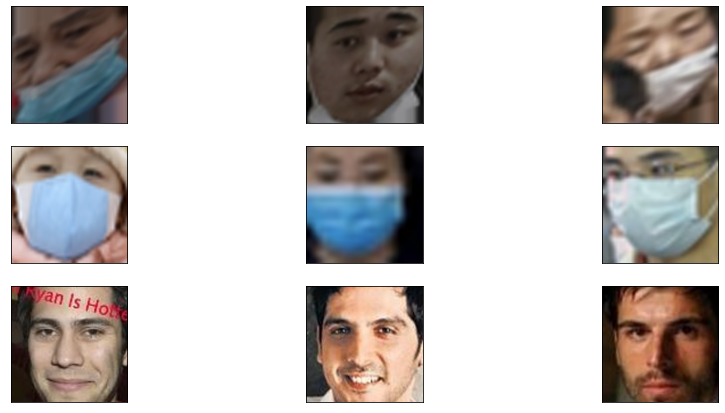

In [10]:
plt.figure(figsize=(15,15))

for i, k in enumerate(all_images):
  plt.subplot(6, 3, i+1)
  plt.imshow(mpimg.imread(k))
  plt.xticks([])
  plt.yticks([])

plt.show()

#Data Splitting

In [11]:
#Persiapan sebelum splitting data
#Membuat folder untuk train dan validasi setiap kelas

path_data_baru = './DatasetNew'
os.mkdir(path_data_baru)

In [12]:
train_dir = os.path.join(path_data_baru, 'train')
test_dir = os.path.join(path_data_baru, 'test')

salahmasker_train = os.path.join(train_dir,'mask_weared_incorrect')
salahmasker_test = os.path.join(test_dir,'mask_weared_incorrect')

masker_train = os.path.join(train_dir,'with_mask')
masker_test = os.path.join(test_dir,'with_mask')

tanpamasker_train = os.path.join(train_dir,'without_mask')
tanpamasker_test = os.path.join(test_dir,'without_mask')

list_dir = [train_dir,test_dir,salahmasker_train,salahmasker_test,
            masker_train,masker_test,tanpamasker_train,tanpamasker_test]

for i in list_dir:
  os.mkdir(i)

In [13]:
#Data splitting dengan validation set = 10% total data

train_salahmasker_dir, test_salahmasker_dir = train_test_split(os.listdir(path_salah_masker), test_size = 0.10,random_state=0)
train_masker_dir, test_masker_dir = train_test_split(os.listdir(path_masker), test_size = 0.10, random_state=0)
train_tanpamasker_dir, test_tanpamasker_dir = train_test_split(os.listdir(path_tanpa_masker), test_size = 0.10, random_state=0)

In [14]:
#Memindahkan hasil split ke folder yang telah dibuat
for i in train_salahmasker_dir:
  shutil.copy(os.path.join(path_salah_masker,i), os.path.join(salahmasker_train,i))
for i in test_salahmasker_dir:
  shutil.copy(os.path.join(path_salah_masker,i), os.path.join(salahmasker_test,i))

for i in train_masker_dir:
  shutil.copy(os.path.join(path_masker,i), os.path.join(masker_train,i))
for i in test_masker_dir:
  shutil.copy(os.path.join(path_masker,i), os.path.join(masker_test,i))

for i in train_tanpamasker_dir:
  shutil.copy(os.path.join(path_tanpa_masker,i), os.path.join(tanpamasker_train,i))
for i in test_tanpamasker_dir:
  shutil.copy(os.path.join(path_tanpa_masker,i), os.path.join(tanpamasker_test,i))

#Image Augmentation

In [15]:
train_datagen = ImageDataGenerator(
                rescale = 1./255, #mengubah nilai matriks/pixel dari 0-255 sampai 0-1
                rotation_range = 20, #memutar gambar 20 derajat
                horizontal_flip = True,
                vertical_flip = True,
                shear_range = 0.2, #distorsi sebanyak 20%
                fill_mode = 'nearest') #hasil distorsi di isi dengan nilai matriks terdekat

test_datagen = ImageDataGenerator(
               rescale = 1./255,
               rotation_range = 20,
               horizontal_flip = True,
               vertical_flip = True,
               shear_range = 0.2,
               fill_mode = 'nearest')

In [16]:
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 128,
                  class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 128,
                 class_mode = 'categorical')

Found 8082 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


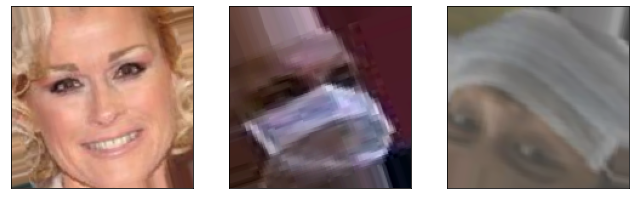

In [17]:
plt.figure(figsize=(15,15))

for i in range(3):
  image = next(train_generator)[0].astype('float64')

  plt.subplot(1, 4, i+1)
  plt.imshow(image[i])
  plt.xticks([])
  plt.yticks([])

plt.show()

#Modelling

In [18]:
model = Sequential()

#konvolusi & maxpooling 1 dengan layer input
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(2,2))

#konvolusi & maxpooling 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

#konvolusi & maxpooling 3
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

#konvolusi & maxpooling 4
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

#flatten
model.add(Flatten())

#Hiden Layer 1
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))

#Hiden Layer 2
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(3, activation = 'softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [20]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [21]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
       self.model.stop_training = True

stopTraining = Callback()

In [22]:
history = model.fit(train_generator,
                    validation_data= test_generator,
                    epochs = 50,
                    callbacks= [stopTraining])

Epoch 1/50
64/64 [==============================] - 60s 744ms/step - loss: 0.5713 - accuracy: 0.7597 - val_loss: 0.3967 - val_accuracy: 0.8433
Epoch 2/50
64/64 [==============================] - 47s 733ms/step - loss: 0.3345 - accuracy: 0.8744 - val_loss: 0.2903 - val_accuracy: 0.8956
Epoch 3/50
64/64 [==============================] - 47s 738ms/step - loss: 0.2506 - accuracy: 0.9071 - val_loss: 0.2353 - val_accuracy: 0.9178
Epoch 4/50
64/64 [==============================] - 46s 723ms/step - loss: 0.2199 - accuracy: 0.9190 - val_loss: 0.2211 - val_accuracy: 0.9256
Epoch 5/50
64/64 [==============================] - 46s 725ms/step - loss: 0.1667 - accuracy: 0.9364 - val_loss: 0.1408 - val_accuracy: 0.9511
Epoch 6/50
64/64 [==============================] - 47s 734ms/step - loss: 0.1175 - accuracy: 0.9568 - val_loss: 0.1195 - val_accuracy: 0.9511
Epoch 7/50
64/64 [==============================] - 47s 728ms/step - loss: 0.1041 - accuracy: 0.9642 - val_loss: 0.1294 - val_accuracy: 0.9544

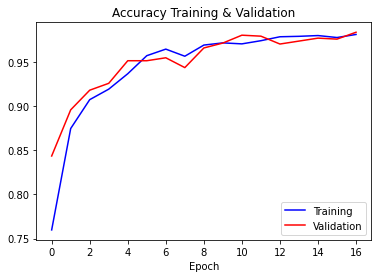

In [23]:
plt.plot(history.history['accuracy'], label='Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='red')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

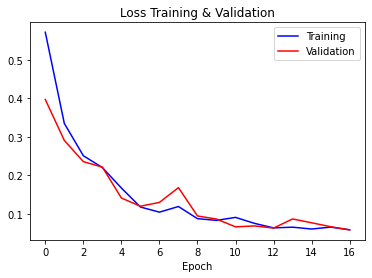

In [24]:
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='red')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [49]:
train_score = model.evaluate(train_generator)

print("[INFO] accuracy train: {:.2f}%".format(train_score[1] * 100)) 

print("[INFO] Loss: ",train_score[0])

64/64 [==============================] - 43s 668ms/step - loss: 0.0331 - accuracy: 0.9896
[INFO] accuracy train: 98.96%
[INFO] Loss:  0.03314928710460663


In [50]:
test_score = model.evaluate(test_generator)

print("[INFO] accuracy test: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

8/8 [==============================] - 5s 563ms/step - loss: 0.0402 - accuracy: 0.9844
[INFO] accuracy test: 98.44%
[INFO] Loss:  0.04022165760397911


# Save & Load Model

In [ ]:
from keras.models import load_model

#save model
model.save('/content/drive/My Drive/model/model_face_mask.h5')

#load model
model_baru = load_model('/content/drive/My Drive/model/model_face_mask.h5')

#Testing

Saving istockphoto-1264106963-170667a.jpg to istockphoto-1264106963-170667a (1).jpg


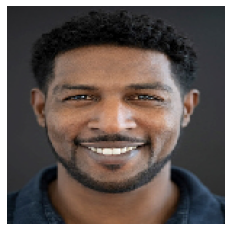

[0. 0. 1.]
Tanpa Masker


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_baru.predict(images, batch_size=10)
  plt.axis('Off')
  plt.imshow(img)
  plt.show()
  print(classes[0])

  if classes[0,0] != 0:
    print('Salah Masker')
  elif classes[0,1] != 0:
    print('Masker')
  else:
    print('Tanpa Masker')